--------------------------------------------------------------------------------

Copyright 2023 Benjamin Alexander Albert [Alejandro Chavez Lab at UCSD]

All Rights Reserved

MAVDA Academic License

hitanalysis.ipynb

--------------------------------------------------------------------------------

In [1]:
import os

from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from platelayout import PlateLayout


sns.set_context("paper", font_scale=1.5)

style="whitegrid"
rc={"font.name"      : "Arial",
    "axes.facecolor" : "0.99",
    "grid.color"     : "0.95",
    "axes.edgecolor" : "0.90"}

plt.rcParams["svg.fonttype"] = "none"

datadir = "data"
hitsdir = "hits"
figsdir = "figs"

os.makedirs(figsdir, exist_ok=True)

countsdir = os.path.join(datadir, "counts")
oddir     = os.path.join(datadir, "od")

pvalposthresh  = 1e-10
magratiothresh = 0.20


def getModelDisplayNames():
    
    return OrderedDict([
    
    ("CCHFV"               , "CCHFV OTU"         ),  #  1
    ("DUGV"                , "DUGV OTU"          ),  #  2
    
    ("NWV"                 , "NWV 3CL"           ),  #  3
    ("SHV"                 , "SHV 3CL"           ),  #  4
    ("LV"                  , "LV 3CL"            ),  #  5
    
    ("Bat-SV-CoVZC45-3CL"  , "Bat-SL-CoVZC45 3CL"),  #  6
    ("SARS-CoV-2-3CL"      , "SARS-CoV-2 3CL"    ),  #  7
    ("SARS-CoV-1-3CL"      , "SARS-CoV 3CL"      ),  #  8
    ("Bat-CoV-HKU9-3CL"    , "Bat-CoV-HKU9 3CL"  ),  #  9
    ("HCoV-HKU1-3CL"       , "HCoV-HKU1 3CL"     ),  # 10
    ("HCoV-OC43-3CL"       , "HCoV-OC43 3CL"     ),  # 11
    ("Bat-CoV-HKU4-3CL"    , "Bat-CoV-HKU4 3CL"  ),  # 12
    ("MERS-CoV-3CL"        , "MERS-CoV 3CL"      ),  # 13
    ("HCoV-229E-3CL"       , "HCoV-229E 3CL"     ),  # 14
    ("HCoV-NL63-3CL"       , "HCoV-NL63 3CL"     ),  # 15
    ("Beluga-CoV-SW1"      , "BWCoV-SW1 3CL"     ),  # 16
    
    ("Bat-SL-CoVZC45-PLP2" , "Bat-SL-CoVZC45 PLP"),  # 17
    ("SARS-CoV-2-PLP"      , "SARS-CoV-2 PLP"    ),  # 18
    ("SARS-CoV-1-PLP"      , "SARS-CoV PLP"      ),  # 19
    ("MERS-CoV-PLP"        , "MERS-CoV PLP"      ),  # 20
    ("HCoV-NL63-PLP2"      , "HCoV-NL63 PLP2"    ),  # 21
    
    ("SLEV"                , "SLEV NS2B-GS-NS3"  ),  # 22
    ("KUNV"                , "KUNV NS2B-GS-NS3"  ),  # 23
    ("WNV"                 , "WNV NS2B-GS-NS3"   ),  # 24
    ("ZIKV"                , "ZIKV NS2B-GS-NS3"  ),  # 25
    ("DENV"                , "DENV NS3-GS-NS2B"  ),  # 26
    ("LGTV"                , "LGTV NS2B-GS-NS3"  ),  # 27
    ("POWV"                , "POWV NS2B-GS-NS3"  ),  
    ("HCV"                 , "HCV NS3-GS-NS4A"   ),  # 29
    
    ("PV"                  , "PV 3C"             ),  # 30
    ("CV-B3"               , "CV-B3 3C"          ),  # 31
    ("HRV-B14"             , "HRV-B14 3C"        ),  # 32
    ("EMCV"                , "EMCV 3C"           ),  # 33
    ("SV-A"                , "SV-A 3C"           ),  # 34
    ("HAV"                 , "HAV 3C"            ),  # 35
    ("HPeV"                , "HPeV 3C"           ),  # 36
    
    ("HTLV"                , "HTLV PR"           ),  # 37
    ("HIV-1"               , "HIV-1 PR"          ),  # 38
    ("HIV-2"               , "HIV-2 PR"          ),  # 39
    
    ("HHV-3"               , "HHV-3 PR"          ),  # 40
    
    ("YES1"                , "YES1"              ),  # 41
    ("c-Src"               , "c-Src"             ),  # 42
    ("FES"                 , "FES"               )]) # 43


def mapOD(df):
    print('-'*80)
    print("mapping ODs...")
    od = list()
    for run in df.run.unique():
        od.append(pd.read_csv(
            os.path.join(oddir, "{}.csv".format(run))))
        od[-1].insert(0, "run", run)
    od = pd.concat(od)
    if len(od) != len(od.groupby(["run","plate","well"])):
        return ValueError("Duplicate run/plate/well tuple found in OD data")
    odmap = {(x.run,x.plate,x.well):x.OD595 for _,x in od.iterrows()}
    df["od"] = df.apply(lambda x: odmap[(x.run,x.plate,x.well)], axis=1)
    return df


def renameGenes(df):
    print("renaming genes...")
    geneRenames = getModelDisplayNames()
    geneRenames.update({
        "DENV-NS3-GS-NS2B" : "DENV NS3-GS-NS2B",
        "HCV-NS3-GS-NS4A"  : "HCV NS3-GS-NS4A",
        "LGTV-NS2B-GS-NS3" : "LGTV NS2B-GS-NS3",
        "POWV-NS2B-GS-NS3" : "POWV NS2B-GS-NS3"})
    for gene in sorted(df.gene.unique()):
        if gene in geneRenames:
            continue
        if gene.split('-')[-1] in ["3C","3CL","PLP","PLP2","PR"]:
            geneRenames[gene] = \
                '-'.join(gene.split('-')[:-1]) + ' ' + gene.split('-')[-1]
        elif ' ' in gene:
            geneRenames[gene] = gene.replace(' ','-')
    for oldgene,newgene in geneRenames.items():
        print("\t{:<19} -> {:<19}".format(oldgene,newgene))
    df.gene = df.gene.apply(lambda x: geneRenames.get(x,x))
    
    return df

def readPlates():
    print('-'*80)
    print("reading list of plates...")
    plates = pd.read_csv(os.path.join(datadir, "plates.csv"))
    print("read {} plates".format(len(plates)))
    plates.run = plates.run.astype(str)
    return plates


def readScores():
    print('-'*80)
    print("reading scores...")
    plates = readPlates()
    df = list()
    for run in plates.run.unique():
        fp = os.path.join(hitsdir, "{}.csv".format(run))
        print("\t{}".format(fp))
        rundf = pd.read_csv(fp)
        rundf["run"] = run
        df.append(rundf)
    df = pd.concat(df)

    df = renameGenes(df)
    
    # Explicitly rename the below rows that do not have counts.
    # Plate NCIDIV_4867  has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    # Plate NCIDIV_4870  has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    # Plate NS1519_22024 has no "HCoV-NL63-PLP", but it has "HCoV-NL63-PLP2"
    print()
    print("making hard-coded gene renamings:")
    print("\tNCIDIV_4867  HCoV-NL63-PLP -> HCoV-NL63-PLP2")
    print("\tNCIDIV_4870  HCoV-NL63-PLP -> HCoV-NL63-PLP2")
    print("\tNS1519_22024 HCoV-NL63-PLP -> HCoV-NL63-PLP2")
    df.loc[(df.plate=="NCIDIV_4867")  & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    df.loc[(df.plate=="NCIDIV_4870")  & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    df.loc[(df.plate=="NS1519_22024") & (df.gene=="HCoV-NL63-PLP"),"gene"] = "HCoV-NL63-PLP2"
    
    print()
    print("prepending zeros to single-digit well indices")
    df.well = df.well.apply(lambda x: "{}{:02d}".format(x[0],int(x[1:])))
    print("read {} rows".format(len(df)))
    
    return df


def mapMagRatios(vals, scores):
    
    print('-'*80)
    print("mapping magratio to validated data...")

    return vals.merge(
        scores,
        how = "left",
        on  = ["compoundsrc","compoundid","gene"])


def mapCompoundWells(df):
    print('-'*80)
    print("mapping compound wells...")
    df["compoundwell"] = df.apply(
        lambda row: PlateLayout(row.plate).getCompoundWell(row.well),
        axis=1)
    print("mapped {} wells".format(len(df)))
    return df


def mapCompounds(df):
    print('-'*80)
    print("mapping compounds...")
    compoundMap = pd.read_csv(
        os.path.join(datadir, "compound_map.csv"),
        dtype={"id" : str})
    if ("compoundsrc" in df.columns) and ("compoundid" in df.columns):
        print(df)
        return df.merge(
            compoundMap,
            how      = "left",
            left_on  = ["compoundsrc", "compoundid"],
            right_on = ["src","id"]).rename(
                {"well":"compoundwell"}, axis=1)
    compoundSrcMap = {(row.plate,row.well):row.src \
        for _,row in compoundMap.iterrows()}
    compoundIdMap = {(row.plate,row.well):row.id \
        for _,row in compoundMap.iterrows()}
    df["compoundsrc"] = df.apply(
        lambda row: compoundSrcMap.get((row.plate,row.compoundwell)),
        axis=1)
    df["compoundid"] = df.apply(
        lambda row: compoundIdMap.get((row.plate,row.compoundwell)),
        axis=1)
    print("mapped {} / {} compounds".format(
        len(df)-df.compoundid.isnull().sum(), len(df)))
    return df


def rmDups(df):
    print('-'*80)
    print("removing duplicate rows ... ")
    origlen = len(df)
    df.drop_duplicates(
        subset       = ["plate","compoundwell","gene"],
        inplace      = True,
        ignore_index = True)
    print("removed {} row(s)".format(origlen-len(df)))
    return df


def readScoreVals():
    
    scores = readScores()
    
    plates = readPlates()
    scores = scores[scores.plate.isin(plates.plate)].copy()
    scores = mapCompoundWells(scores)
    
    vals   = pd.read_csv(
        os.path.join(datadir, "validations.csv"),
        dtype={"compoundid":str})
    vals   = vals.drop("magratio", axis=1)
    vals   = renameGenes(vals)
    vals   = mapCompounds(vals)
    scores = mapCompounds(scores)
    
    vals = rmDups(vals)

    vals = mapMagRatios(
        vals   = vals,
        scores = scores)
    
    return scores, vals


scores, vals = readScoreVals()

--------------------------------------------------------------------------------
reading scores...
--------------------------------------------------------------------------------
reading list of plates...
read 31 plates
	hits/210525.csv
	hits/200922.csv
	hits/201020.csv
	hits/220718.csv
renaming genes...
	CCHFV               -> CCHFV OTU          
	DUGV                -> DUGV OTU           
	NWV                 -> NWV 3CL            
	SHV                 -> SHV 3CL            
	LV                  -> LV 3CL             
	Bat-SV-CoVZC45-3CL  -> Bat-SL-CoVZC45 3CL 
	SARS-CoV-2-3CL      -> SARS-CoV-2 3CL     
	SARS-CoV-1-3CL      -> SARS-CoV 3CL       
	Bat-CoV-HKU9-3CL    -> Bat-CoV-HKU9 3CL   
	HCoV-HKU1-3CL       -> HCoV-HKU1 3CL      
	HCoV-OC43-3CL       -> HCoV-OC43 3CL      
	Bat-CoV-HKU4-3CL    -> Bat-CoV-HKU4 3CL   
	MERS-CoV-3CL        -> MERS-CoV 3CL       
	HCoV-229E-3CL       -> HCoV-229E 3CL      
	HCoV-NL63-3CL       -> HCoV-NL63 3CL      
	Beluga-CoV-SW1      -> BWCoV-SW1

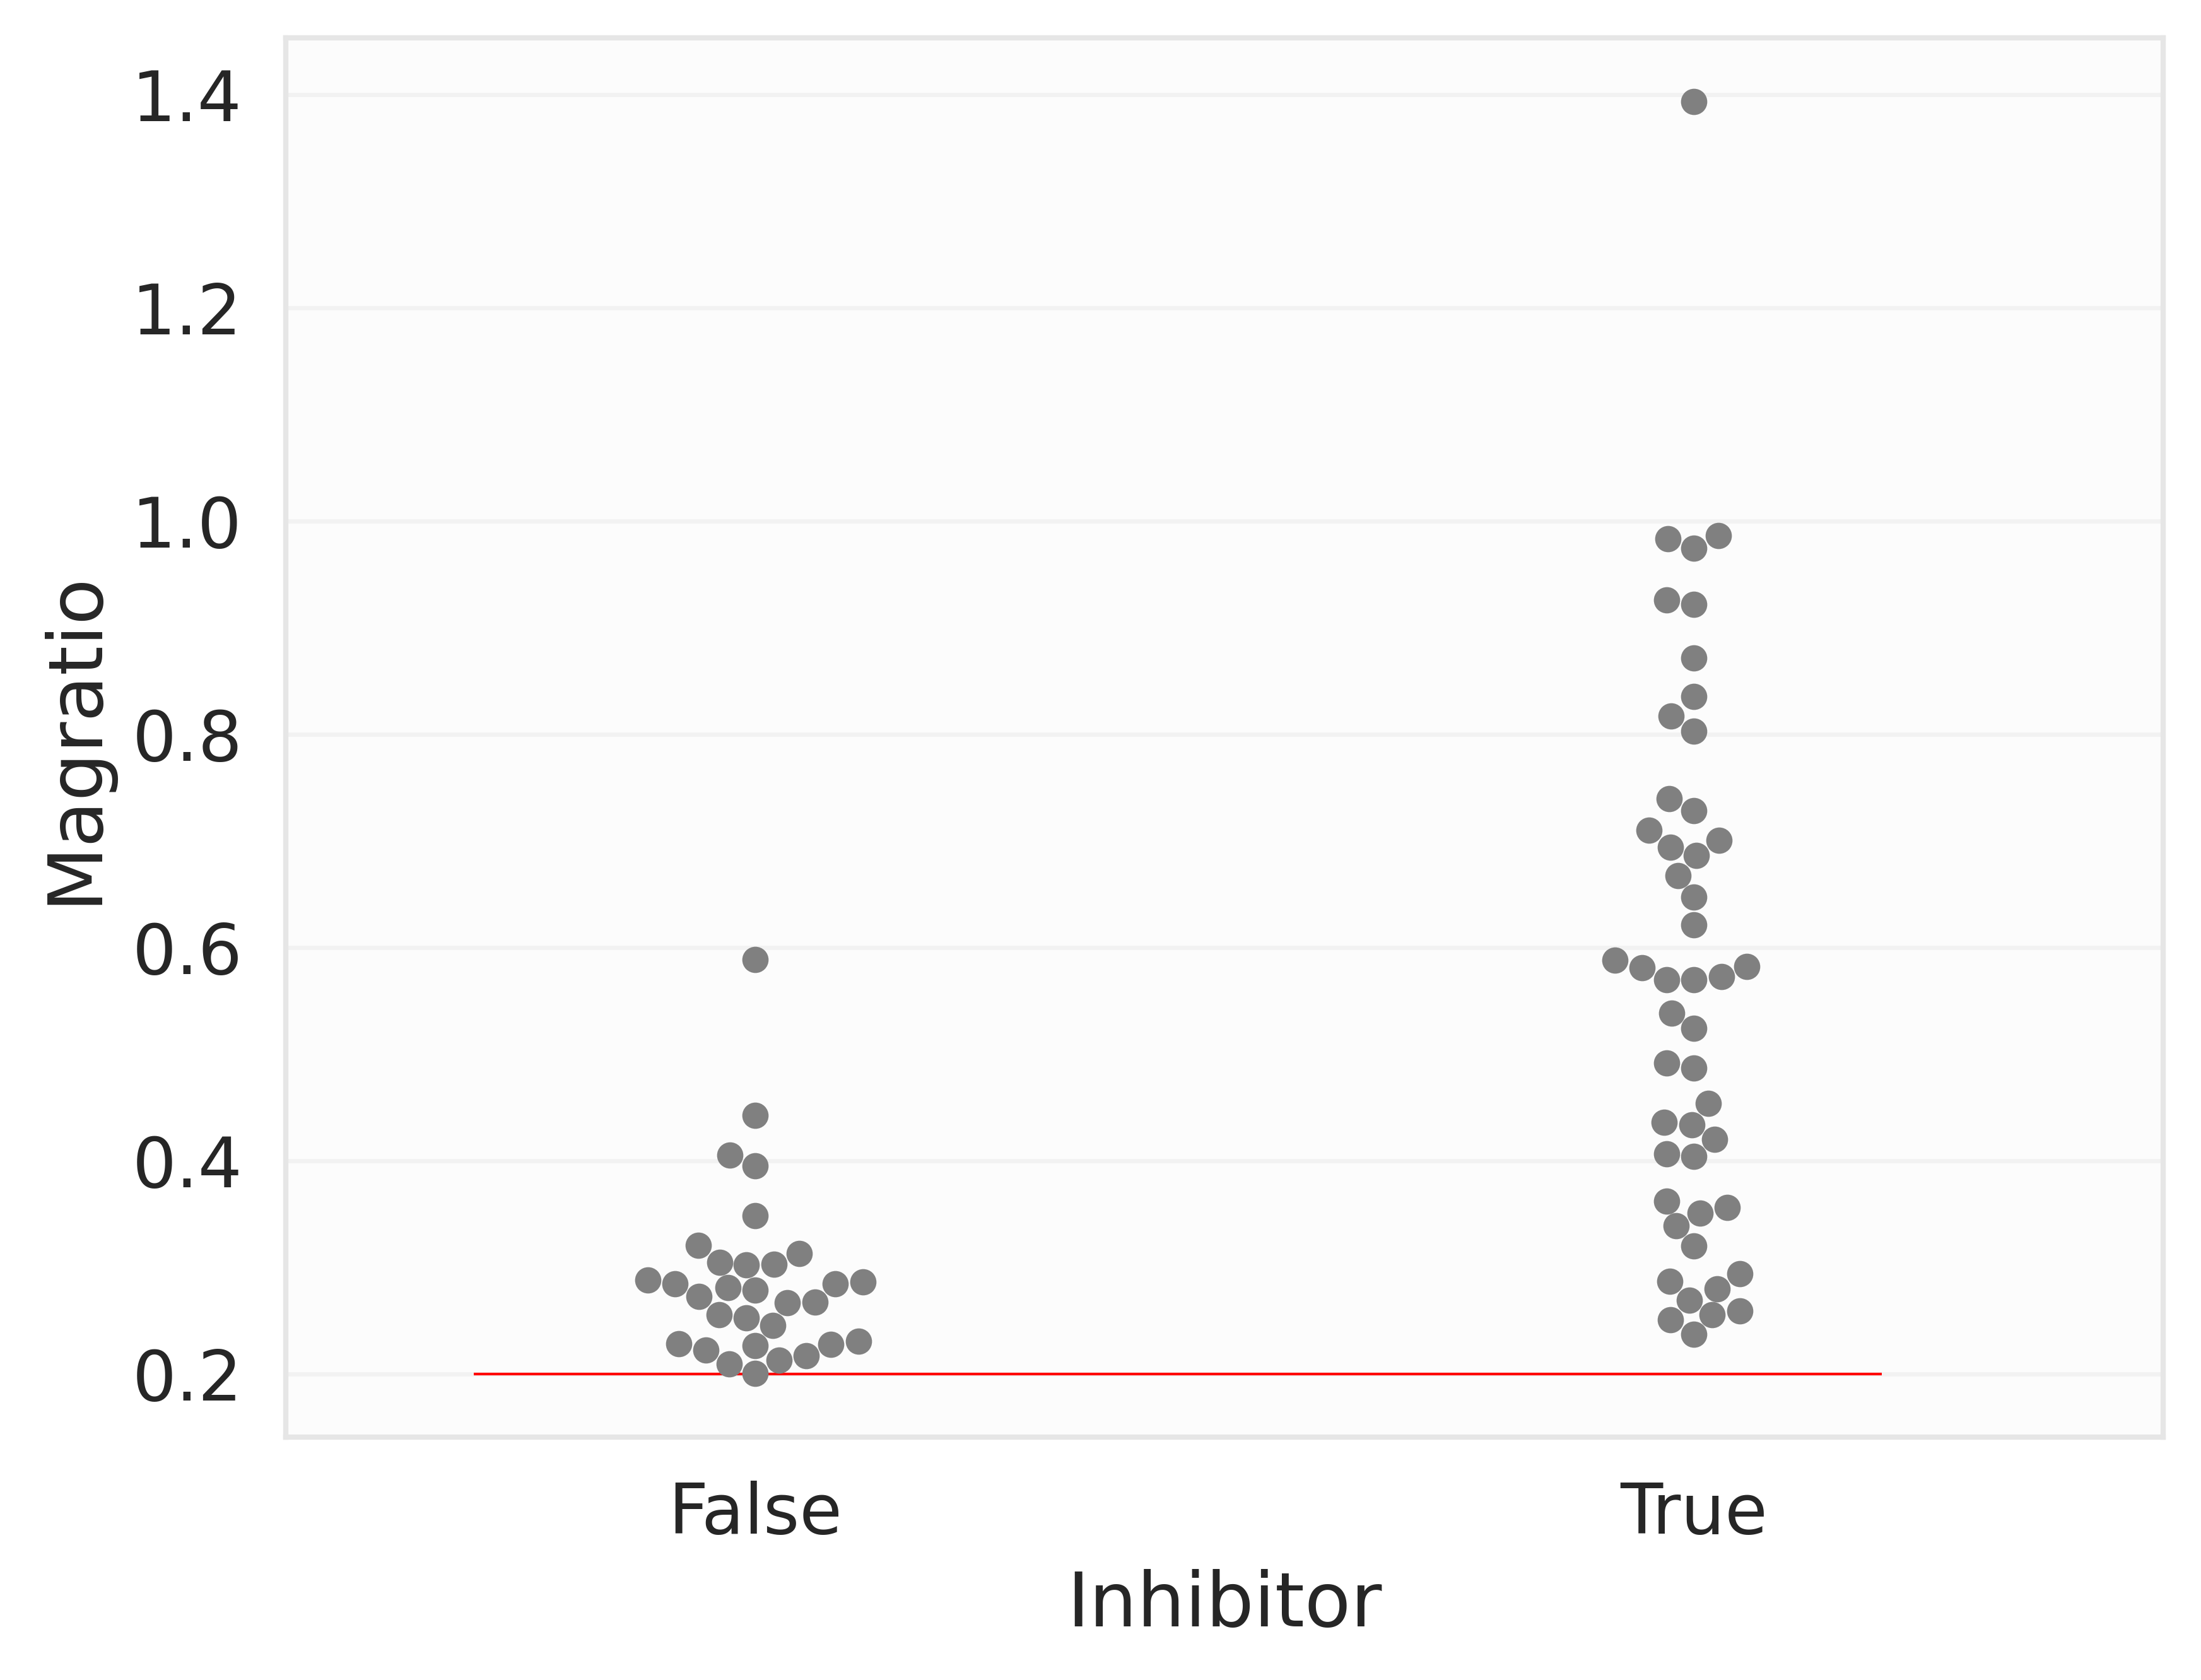

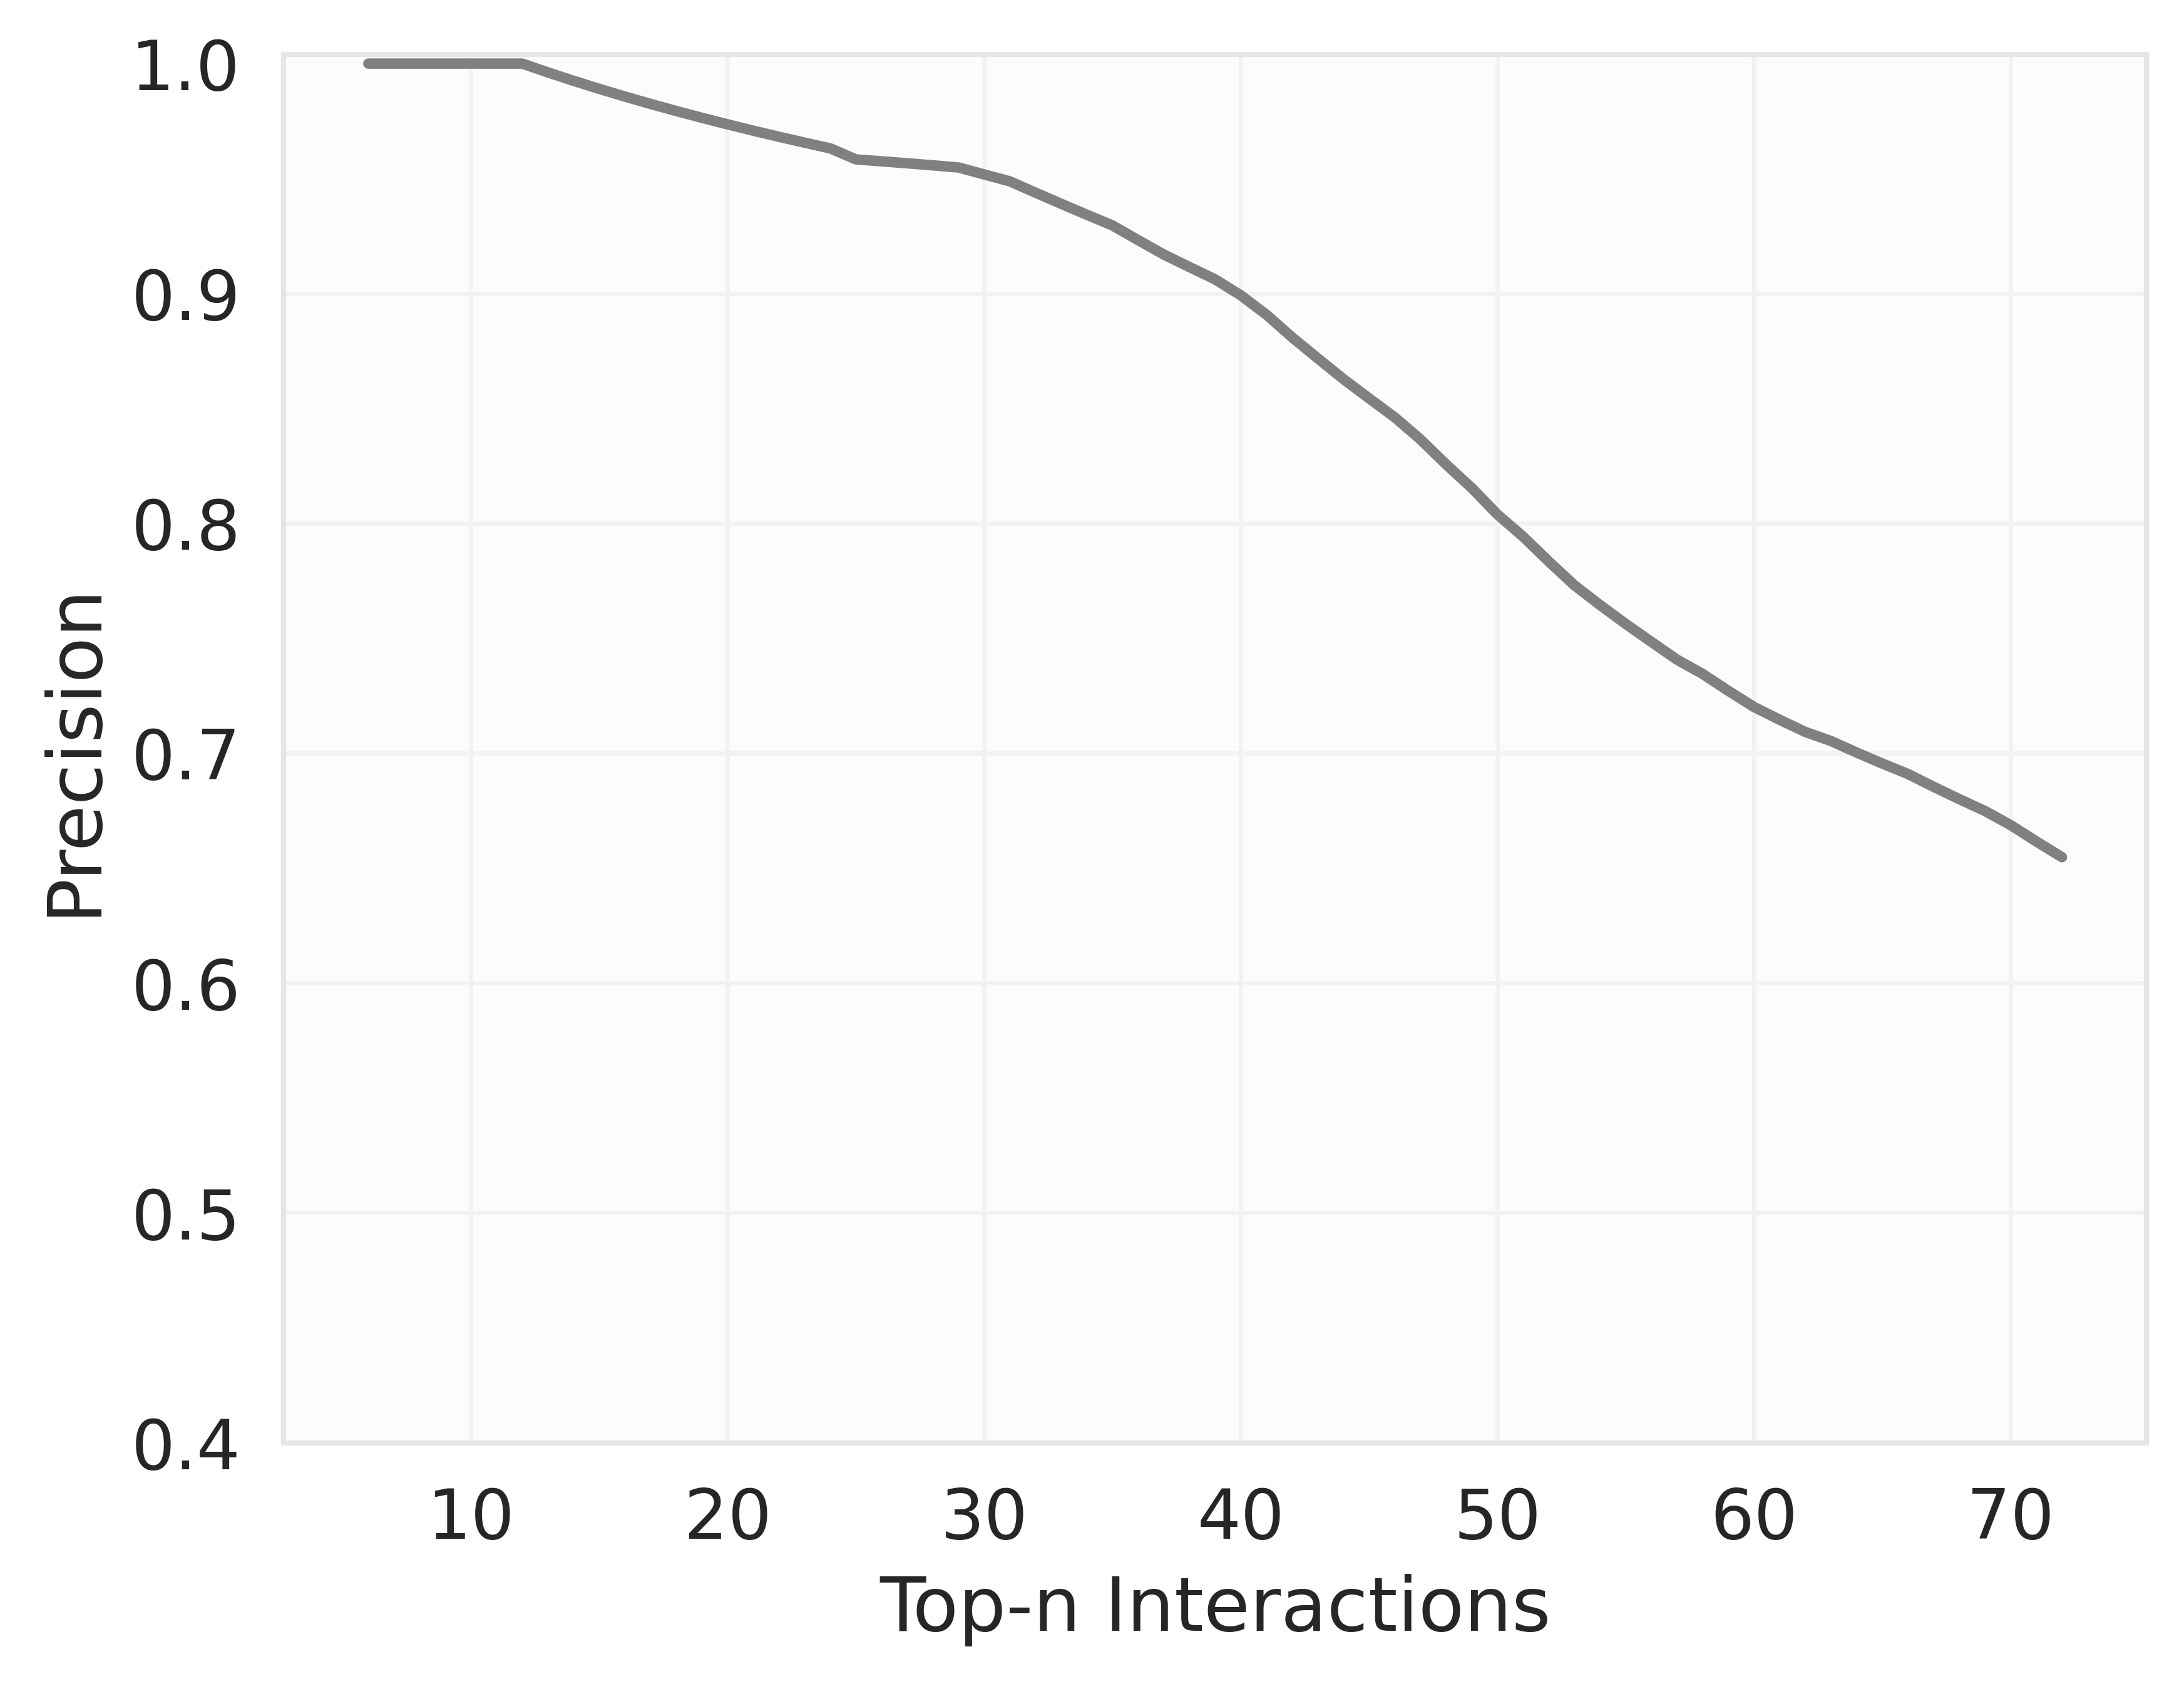

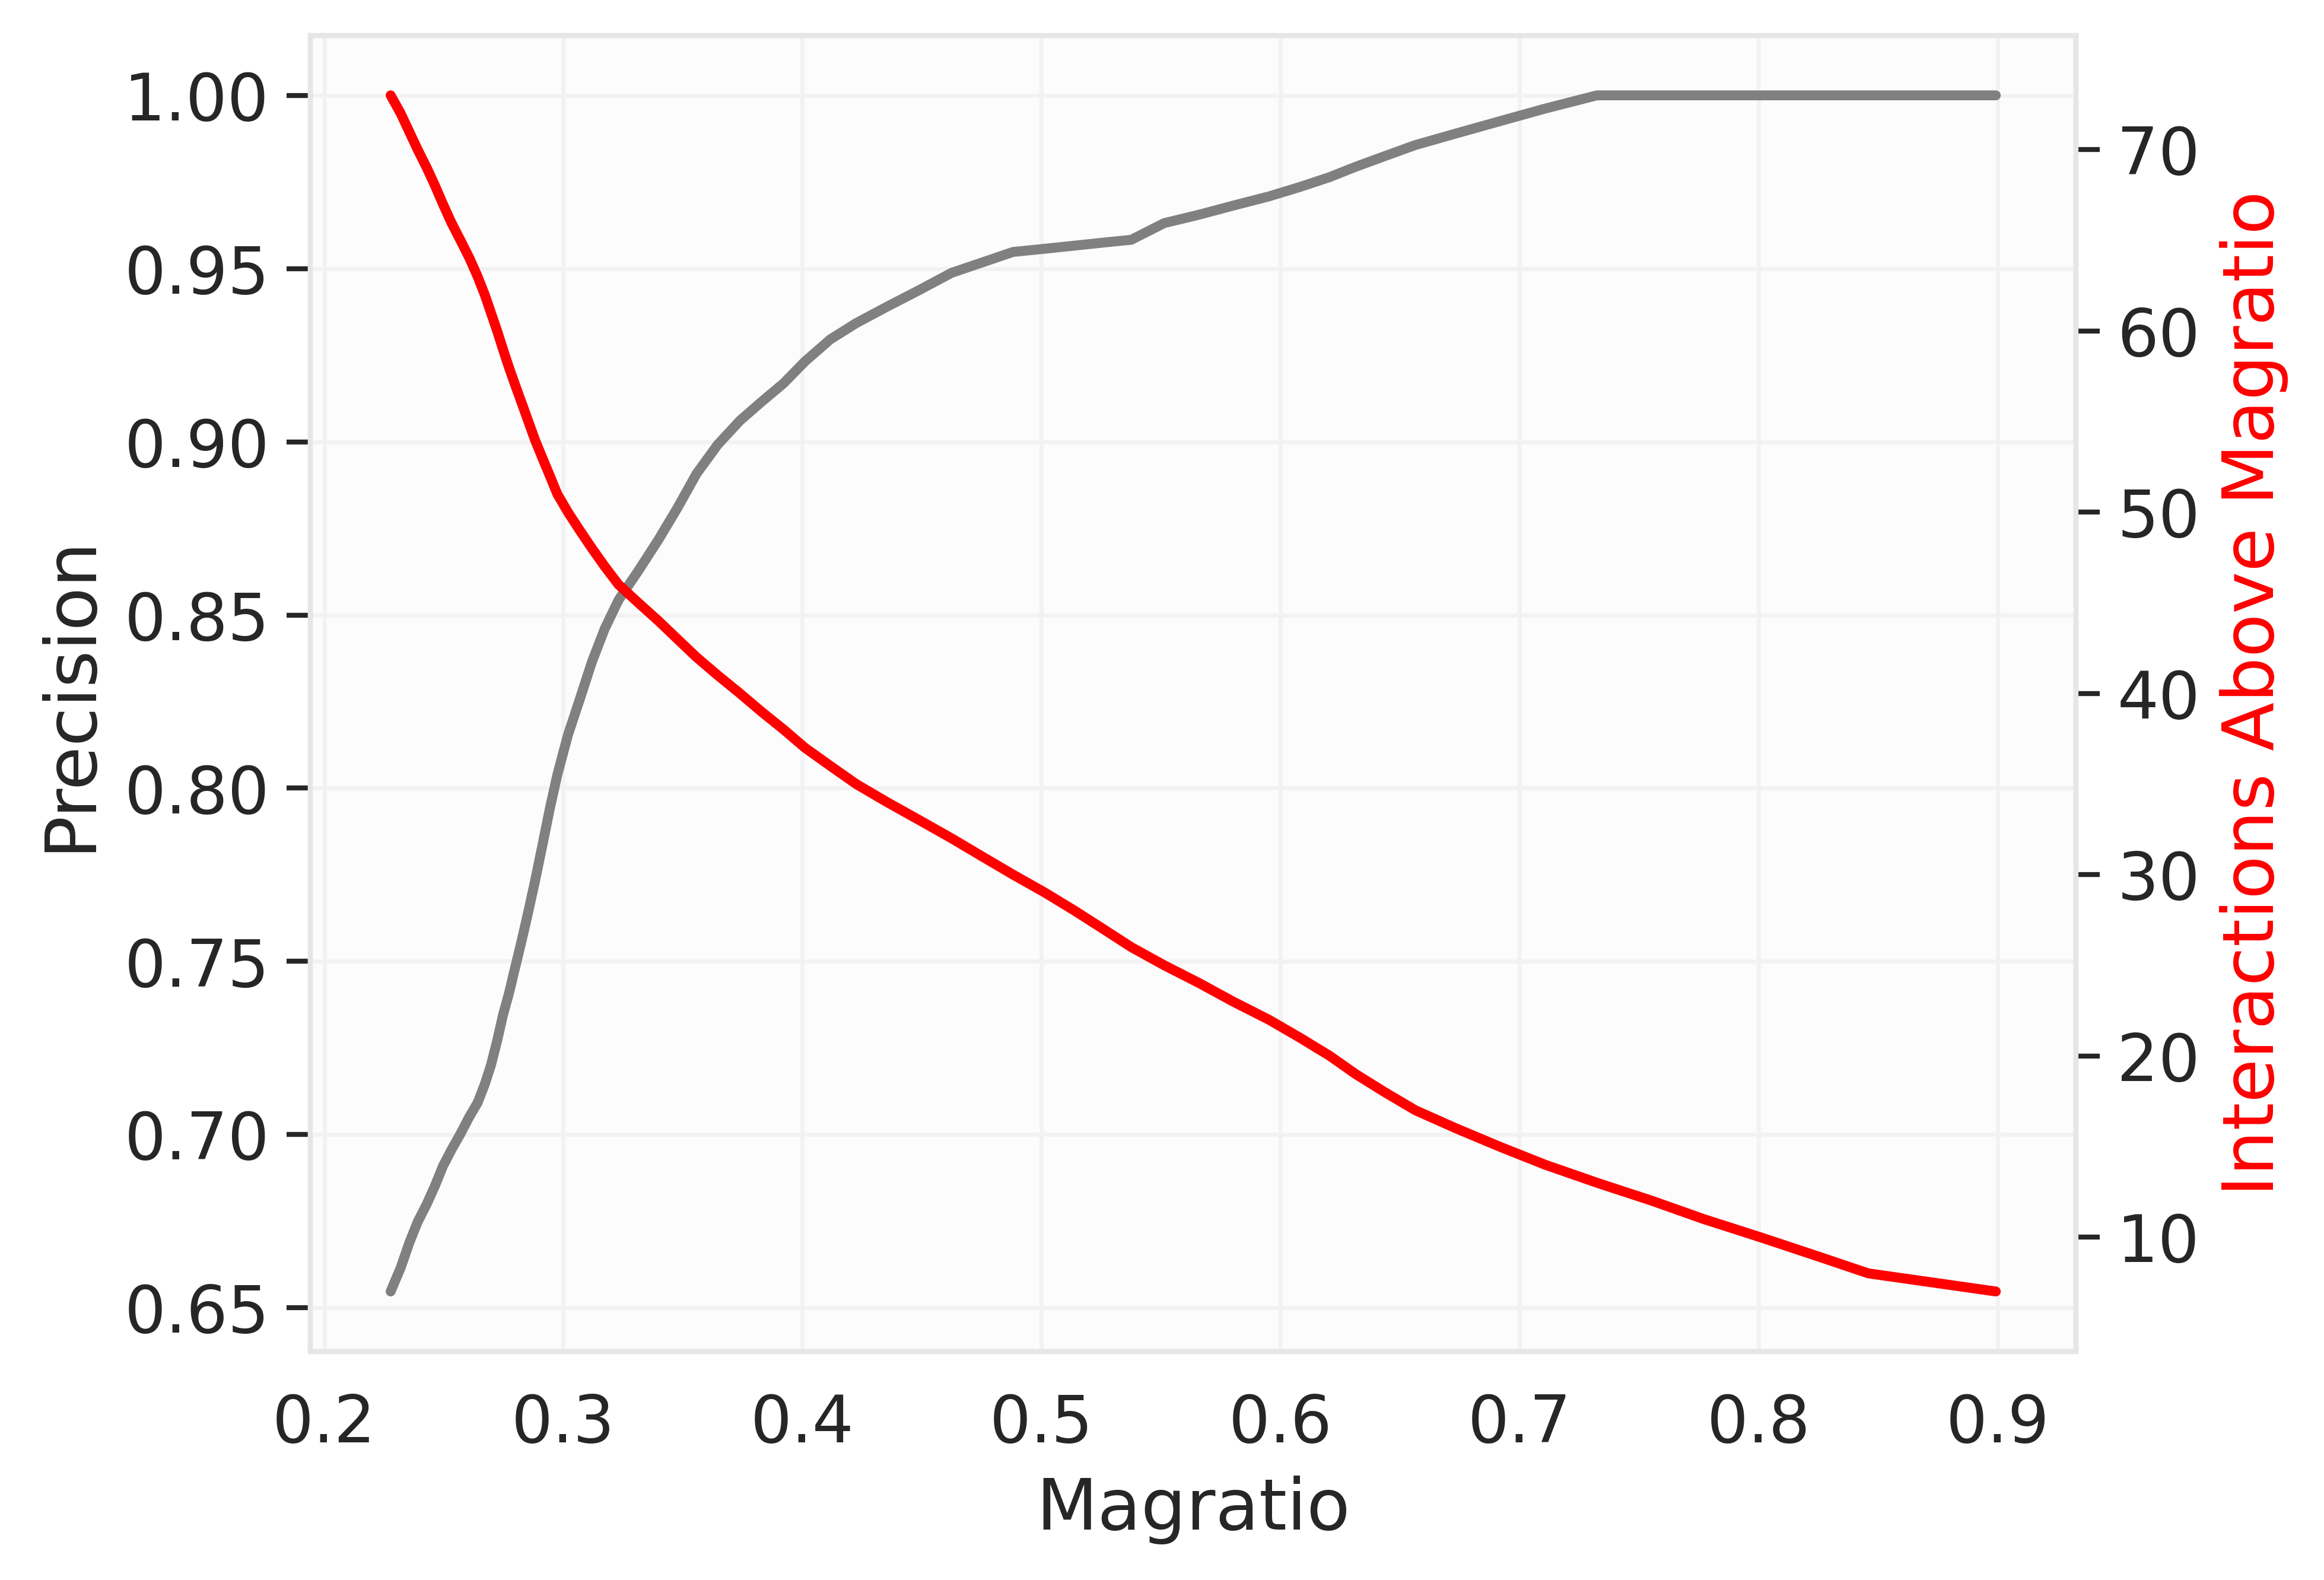

In [2]:
def plotMagratios(vals):
    
    with sns.axes_style(style=style, rc=rc):
        
        fig = plt.figure(dpi=600)
        
        plt.hlines(
                y=magratiothresh,
                xmin=-0.30,
                xmax= 1.20,
                color="red",
                linewidth=0.5)

        sns.swarmplot(vals[vals.magratio > magratiothresh], x="inhibitor", y="magratio", color="gray")
        
        plt.xlabel("Inhibitor")
        plt.ylabel("Magratio")

        fig.savefig(os.path.join(figsdir,"fig_3b.svg"), format="svg", bbox_inches="tight")


def rollingmean(vec, width):
    return np.convolve(vec, np.ones(width), "valid") / width


def plotPPVn(vals, convwidth=1):
    
    with sns.axes_style(style=style, rc=rc):
        
        vals = vals[vals.magratio > magratiothresh].copy()
        vals = vals.copy().sort_values(by="magratio", ascending=False)
        ppvn = list()
        tp = 0
        for x,(_,row) in enumerate(vals.iterrows()):
            if row.inhibitor:
                tp += 1
            ppvn.append(tp / (x+1))

        topn = np.arange(len(ppvn))
        if convwidth > 1:
            ppvn = rollingmean(ppvn, width=convwidth)
            topn = rollingmean(topn, width=convwidth)
        
        plt.figure(dpi=600)
        ax = plt.plot(topn, ppvn, color="gray", linewidth=2)
        plt.ylim([0.40,1.004])
        plt.xlabel("Top-n Interactions")
        plt.ylabel("Precision")
        gridlines = plt.gca().get_ygridlines()[-2].set_visible(False)
        plt.show()


def plotMagratioPrecision(vals, convwidth=1):
    
    with sns.axes_style(style=style, rc=rc):
        
        vals = vals[vals.magratio > magratiothresh].copy()
        vals = vals.copy().sort_values(by="magratio", ascending=False)
        ppvn = list()
        tp = 0
        for x,(_,row) in enumerate(vals.iterrows()):
            if row.inhibitor:
                tp += 1
            ppvn.append(tp / (x+1))

        highpass = list()
        for _,row in vals.iterrows():
            highpass.append((vals.magratio >= row.magratio).sum())

        magratios = vals.magratio.to_numpy()

        pd.DataFrame({"magratio":magratios, "ppvn":ppvn, "highpass":highpass}).to_csv(
            os.path.join(datadir, "magprec.csv"),
            index = False)
        
        if convwidth > 1:
            magratios = rollingmean(magratios, width=convwidth)
            highpass  = rollingmean(highpass, width=convwidth)
            ppvn      = rollingmean(ppvn, width=convwidth)

        fig, ax1 = plt.subplots(dpi=600)
        ax1.plot(magratios, ppvn, color="gray", linewidth=2)
        ax2 = ax1.twinx()
        ax2.plot(magratios, highpass, color="red", linewidth=2)
        ax1.set_xlabel("Magratio")
        ax1.set_ylabel("Precision")
        ax2.set_ylabel("Interactions Above Magratio", color="red")
        ax2.grid(False)

        pd.DataFrame({"magratio":magratios, "ppvn":ppvn, "highpass":highpass}).to_csv(
            os.path.join(datadir, "magprec_rollavg{}.csv".format(convwidth)),
            index = False)

        fig.savefig(os.path.join(figsdir,"fig_3c.svg"), format="svg", bbox_inches="tight")


plotMagratios(vals)
plotPPVn(vals, convwidth=13)
plotMagratioPrecision(vals, convwidth=13)

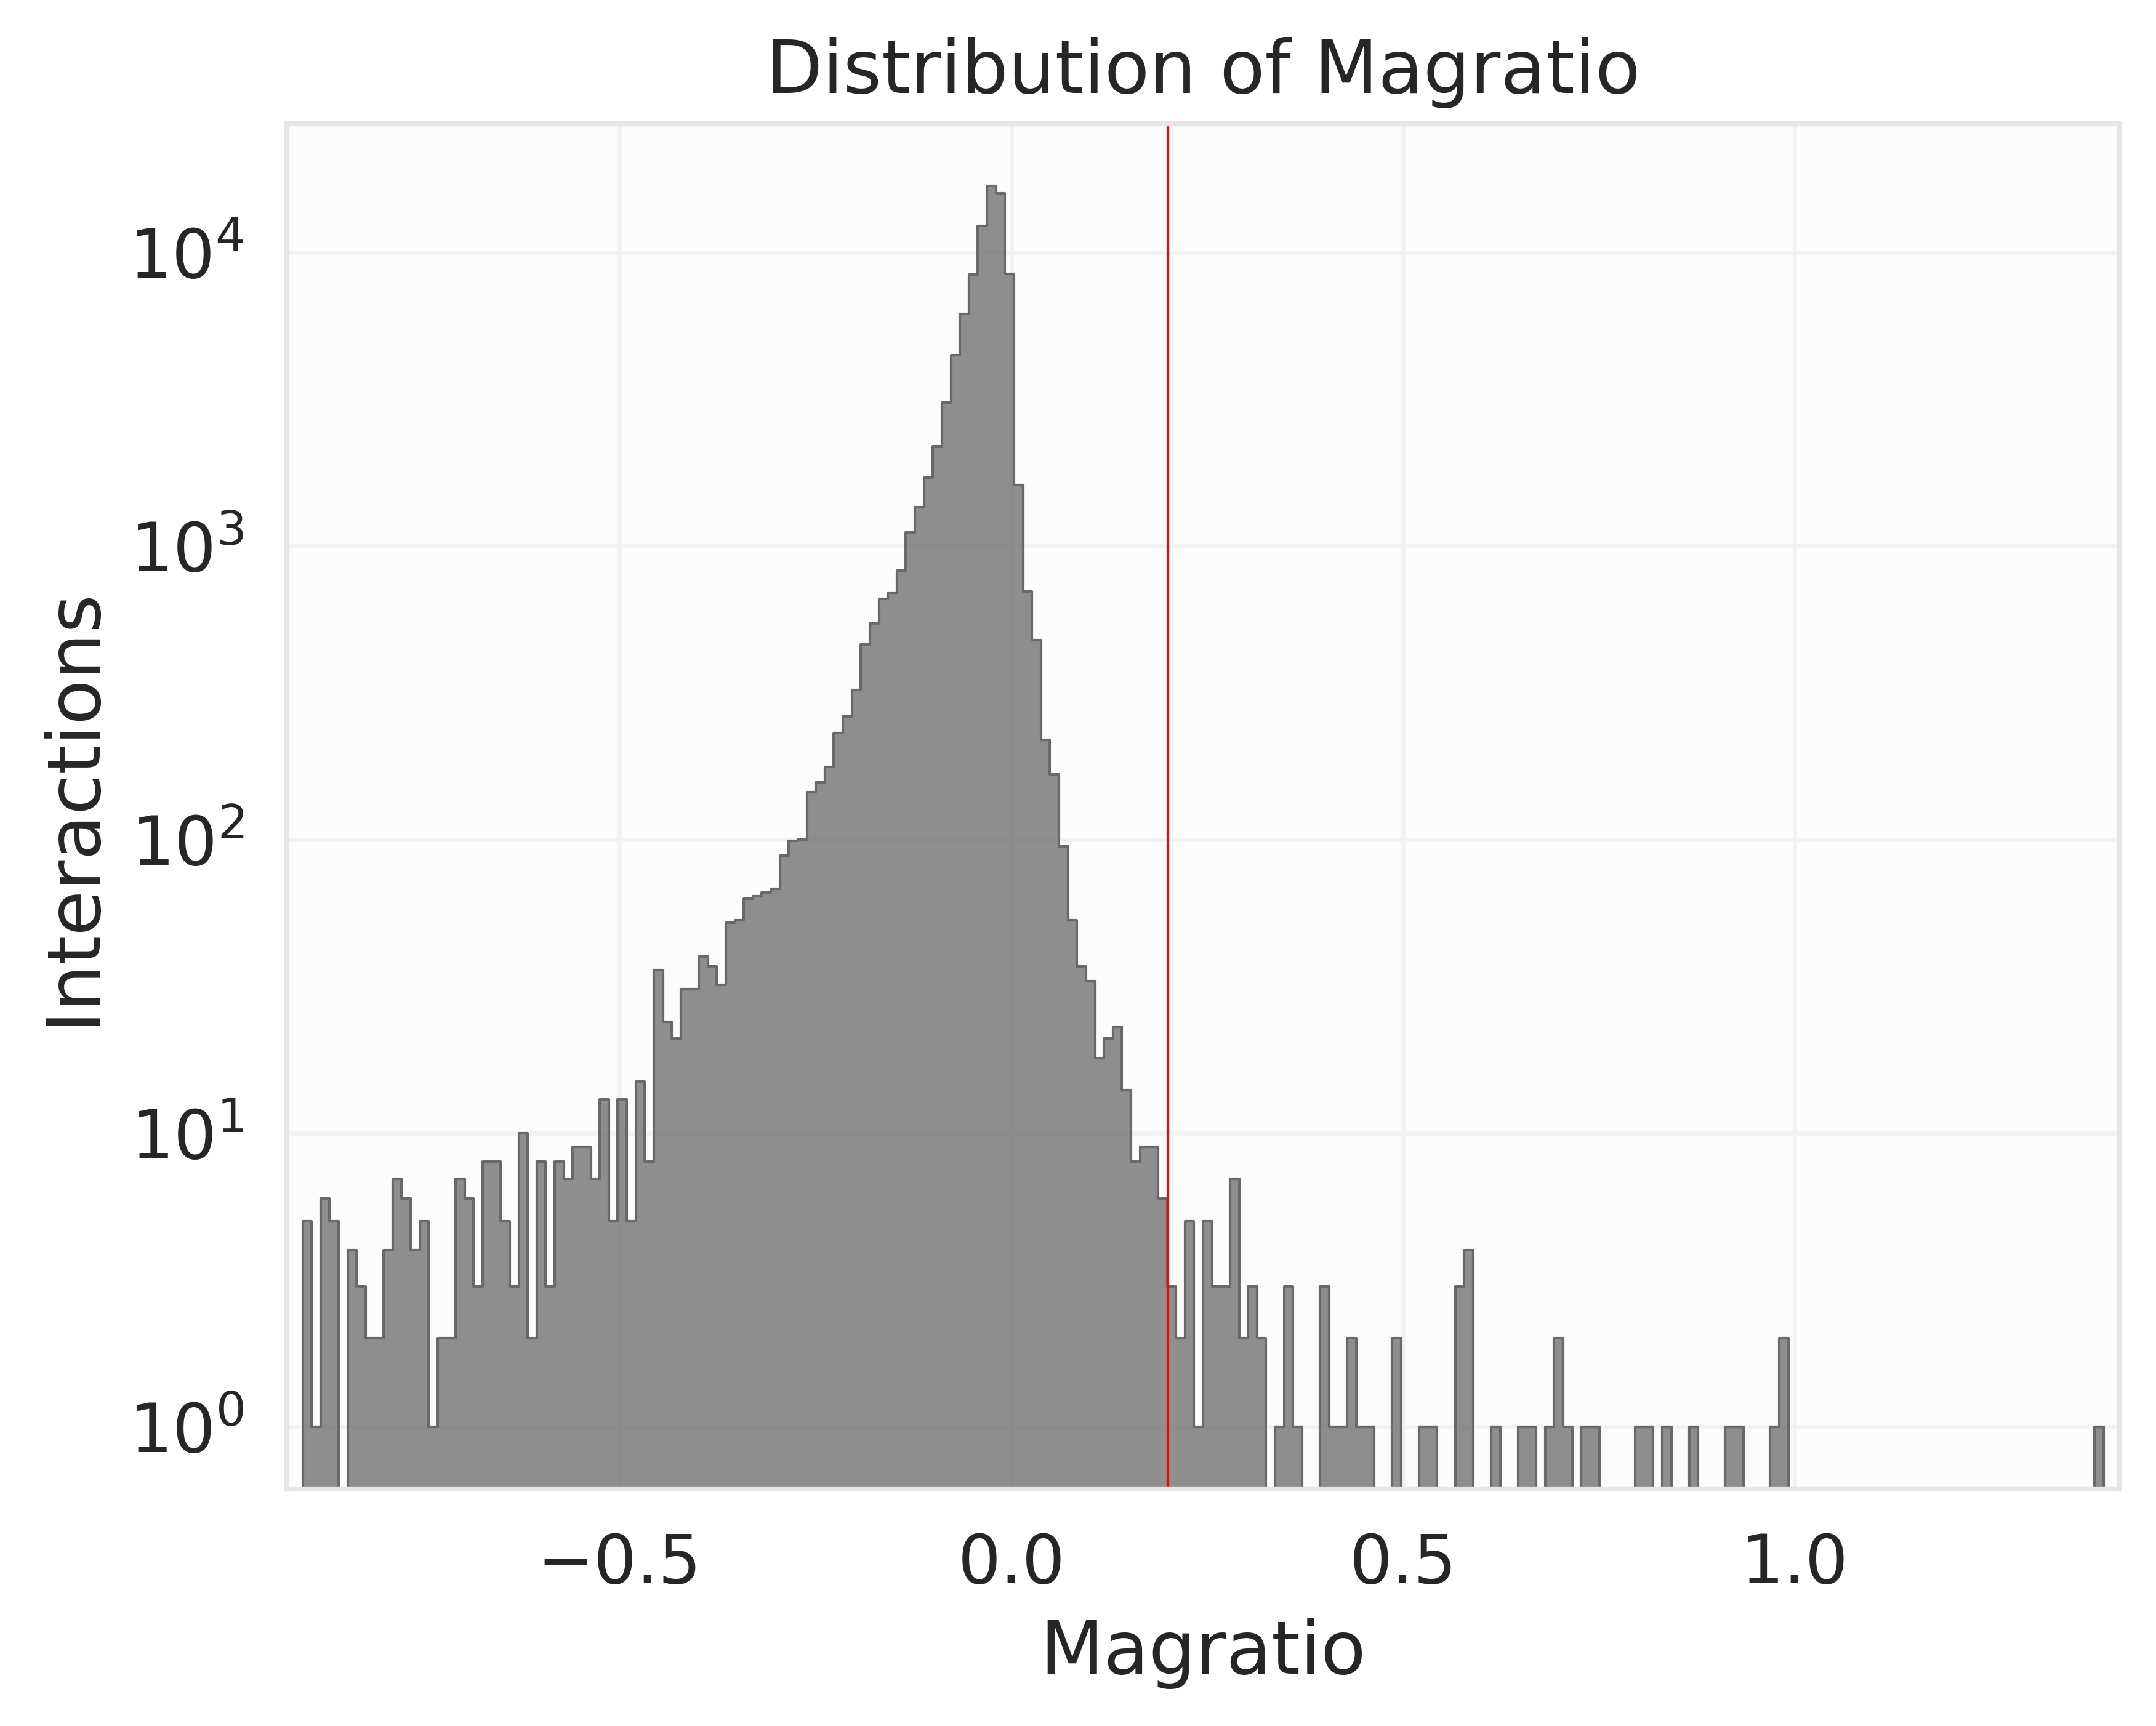

In [3]:
def makeMagRatioHist(scores):
    
    with sns.axes_style(style=style, rc=rc):
        
        fig = plt.figure(dpi=600)
        plt.yscale("log")
        magratios = scores[scores.apply(
            lambda row:
                (row.pvalpos < pvalposthresh) &
                (row.well not in PlateLayout(row.plate).getPosCtrl()),
            axis=1)].magratio
        ax = sns.histplot(
            x=magratios,
            bins=200,
            color="dimgray",
            element="step",
            linewidth=0.5)
        
        plt.vlines(
                x=magratiothresh,
                ymin=0,
                ymax=30000,
                color="red",
                linewidth=0.5)
        plt.xlim([min(magratios)-0.02, max(magratios)+0.02])
        plt.xlabel("Magratio")
        plt.ylabel("Interactions")
        plt.title("Distribution of Magratio")
        
        fig.savefig(os.path.join(figsdir,"fig_s5a.svg"), format="svg", bbox_inches="tight")

makeMagRatioHist(scores)

--------------------------------------------------------------------------------
reading list of plates...
read 31 plates


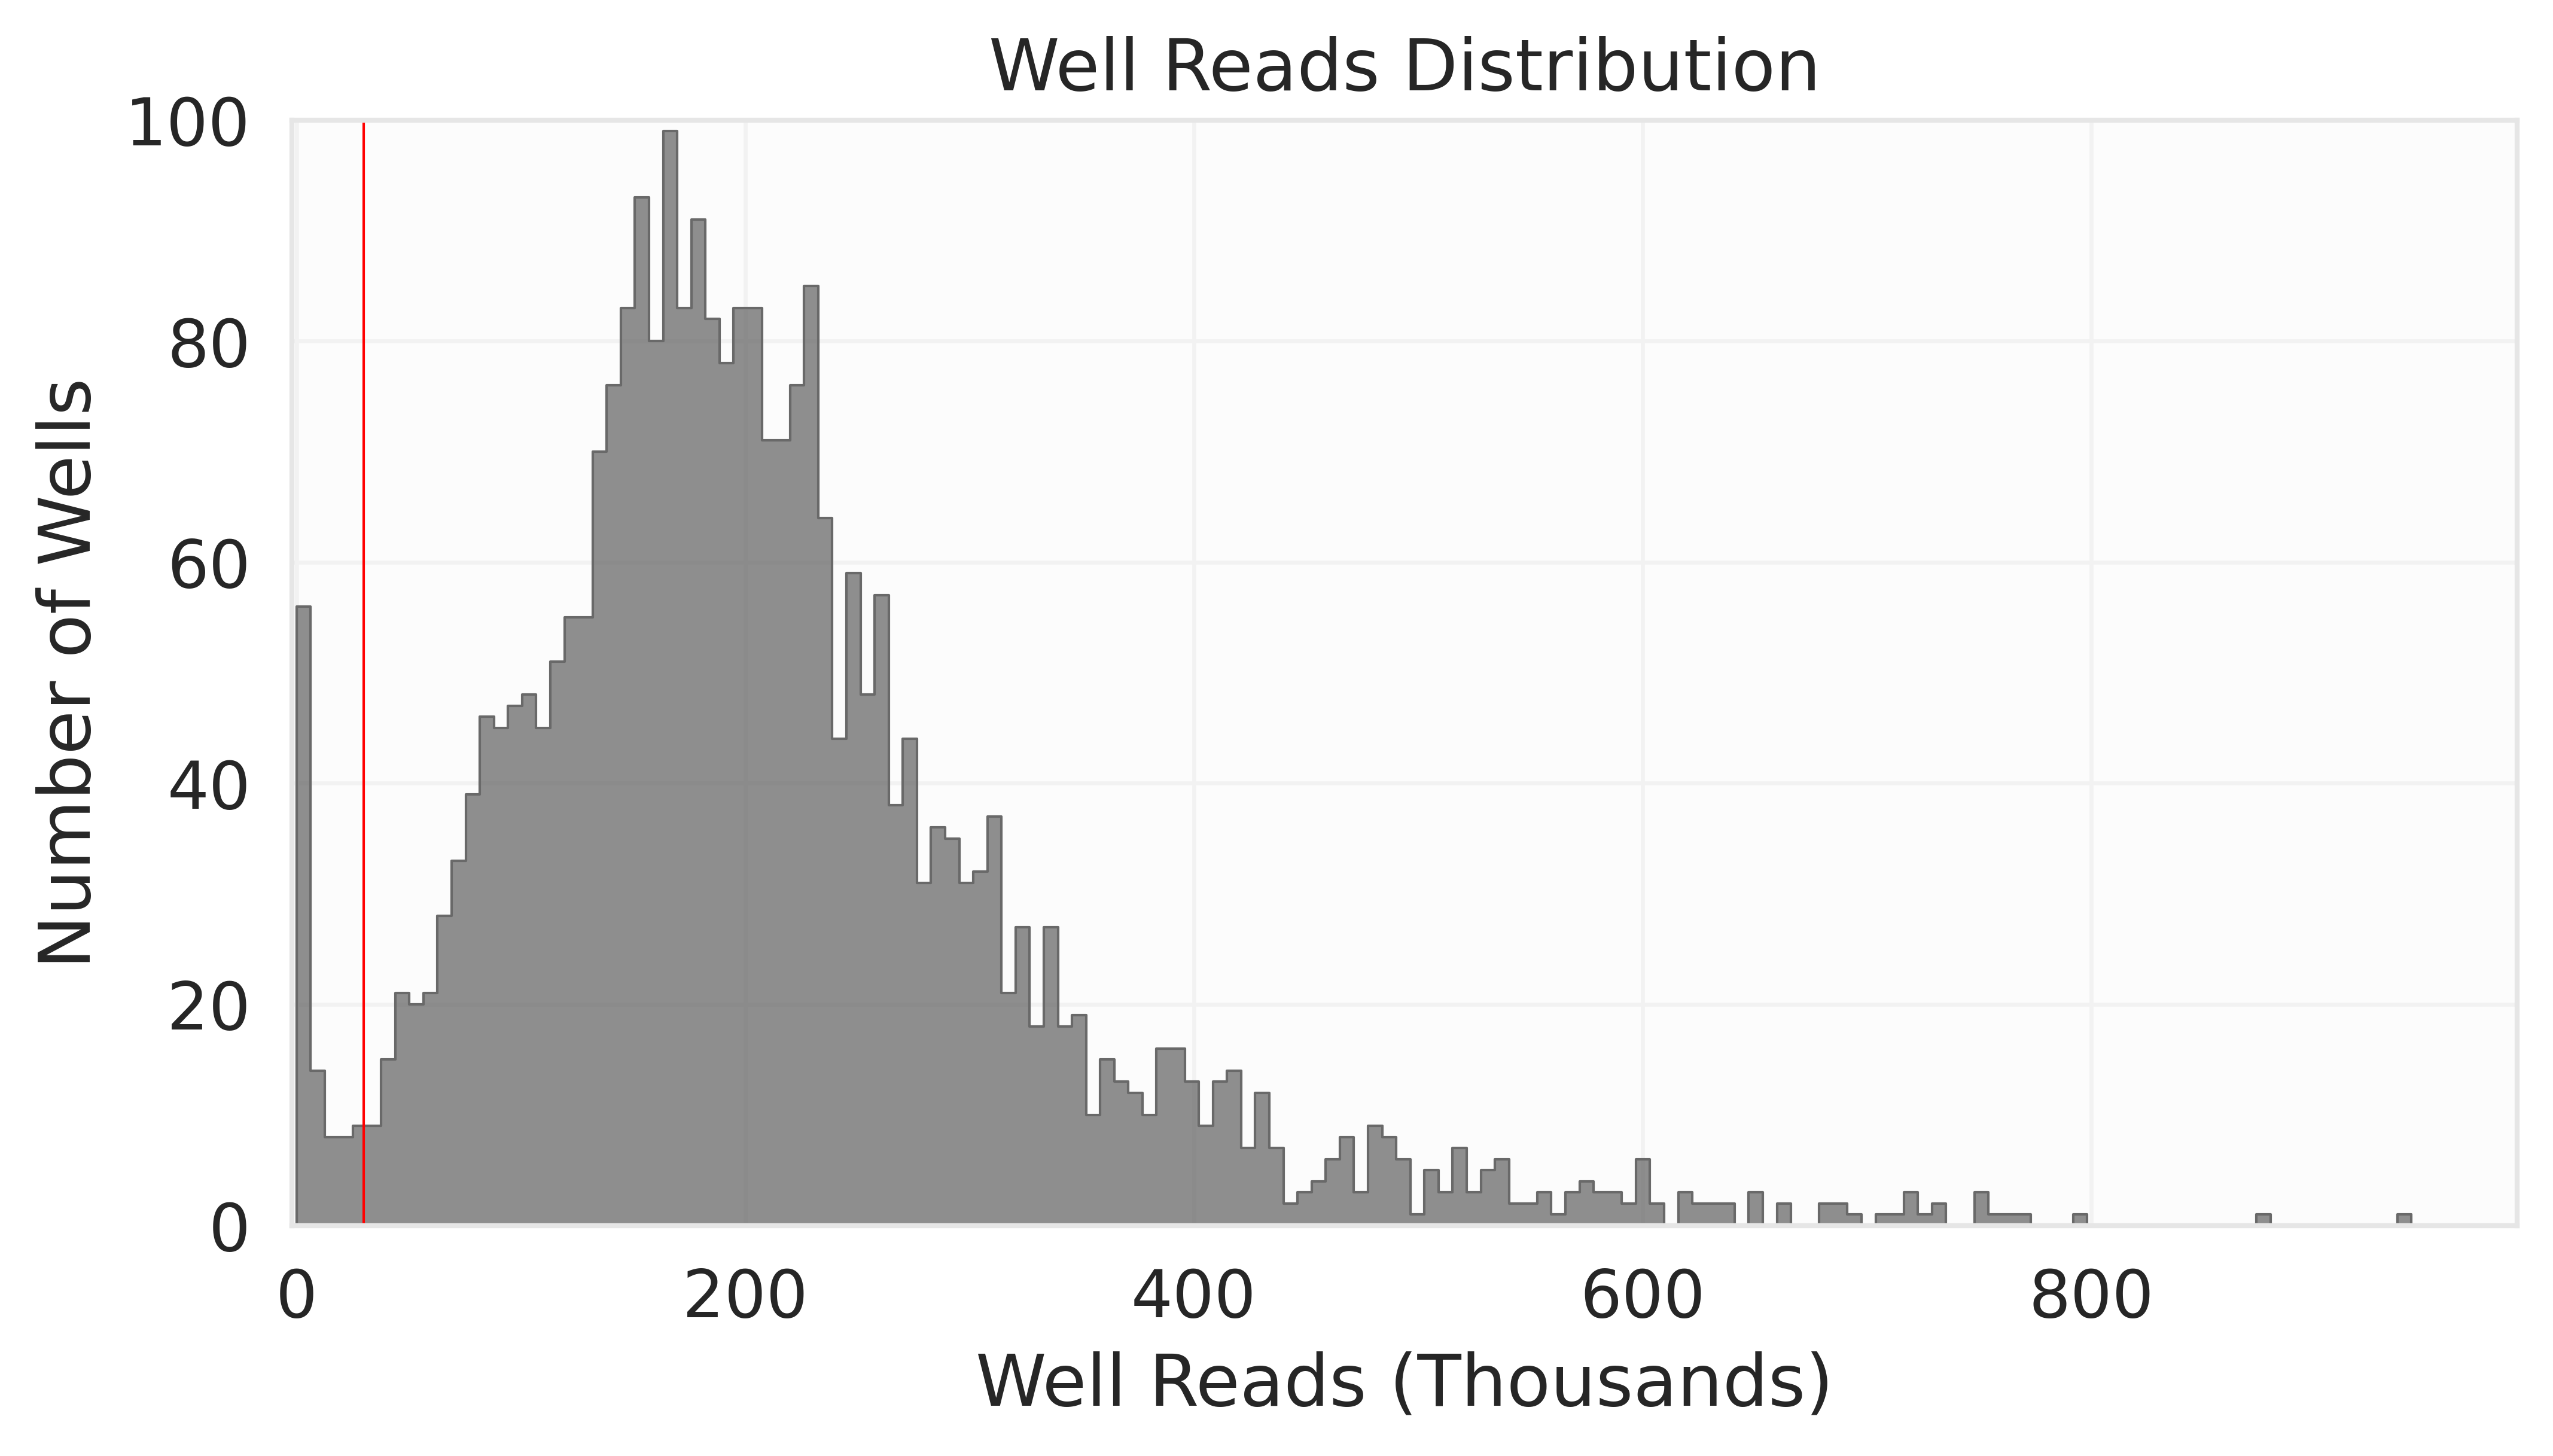

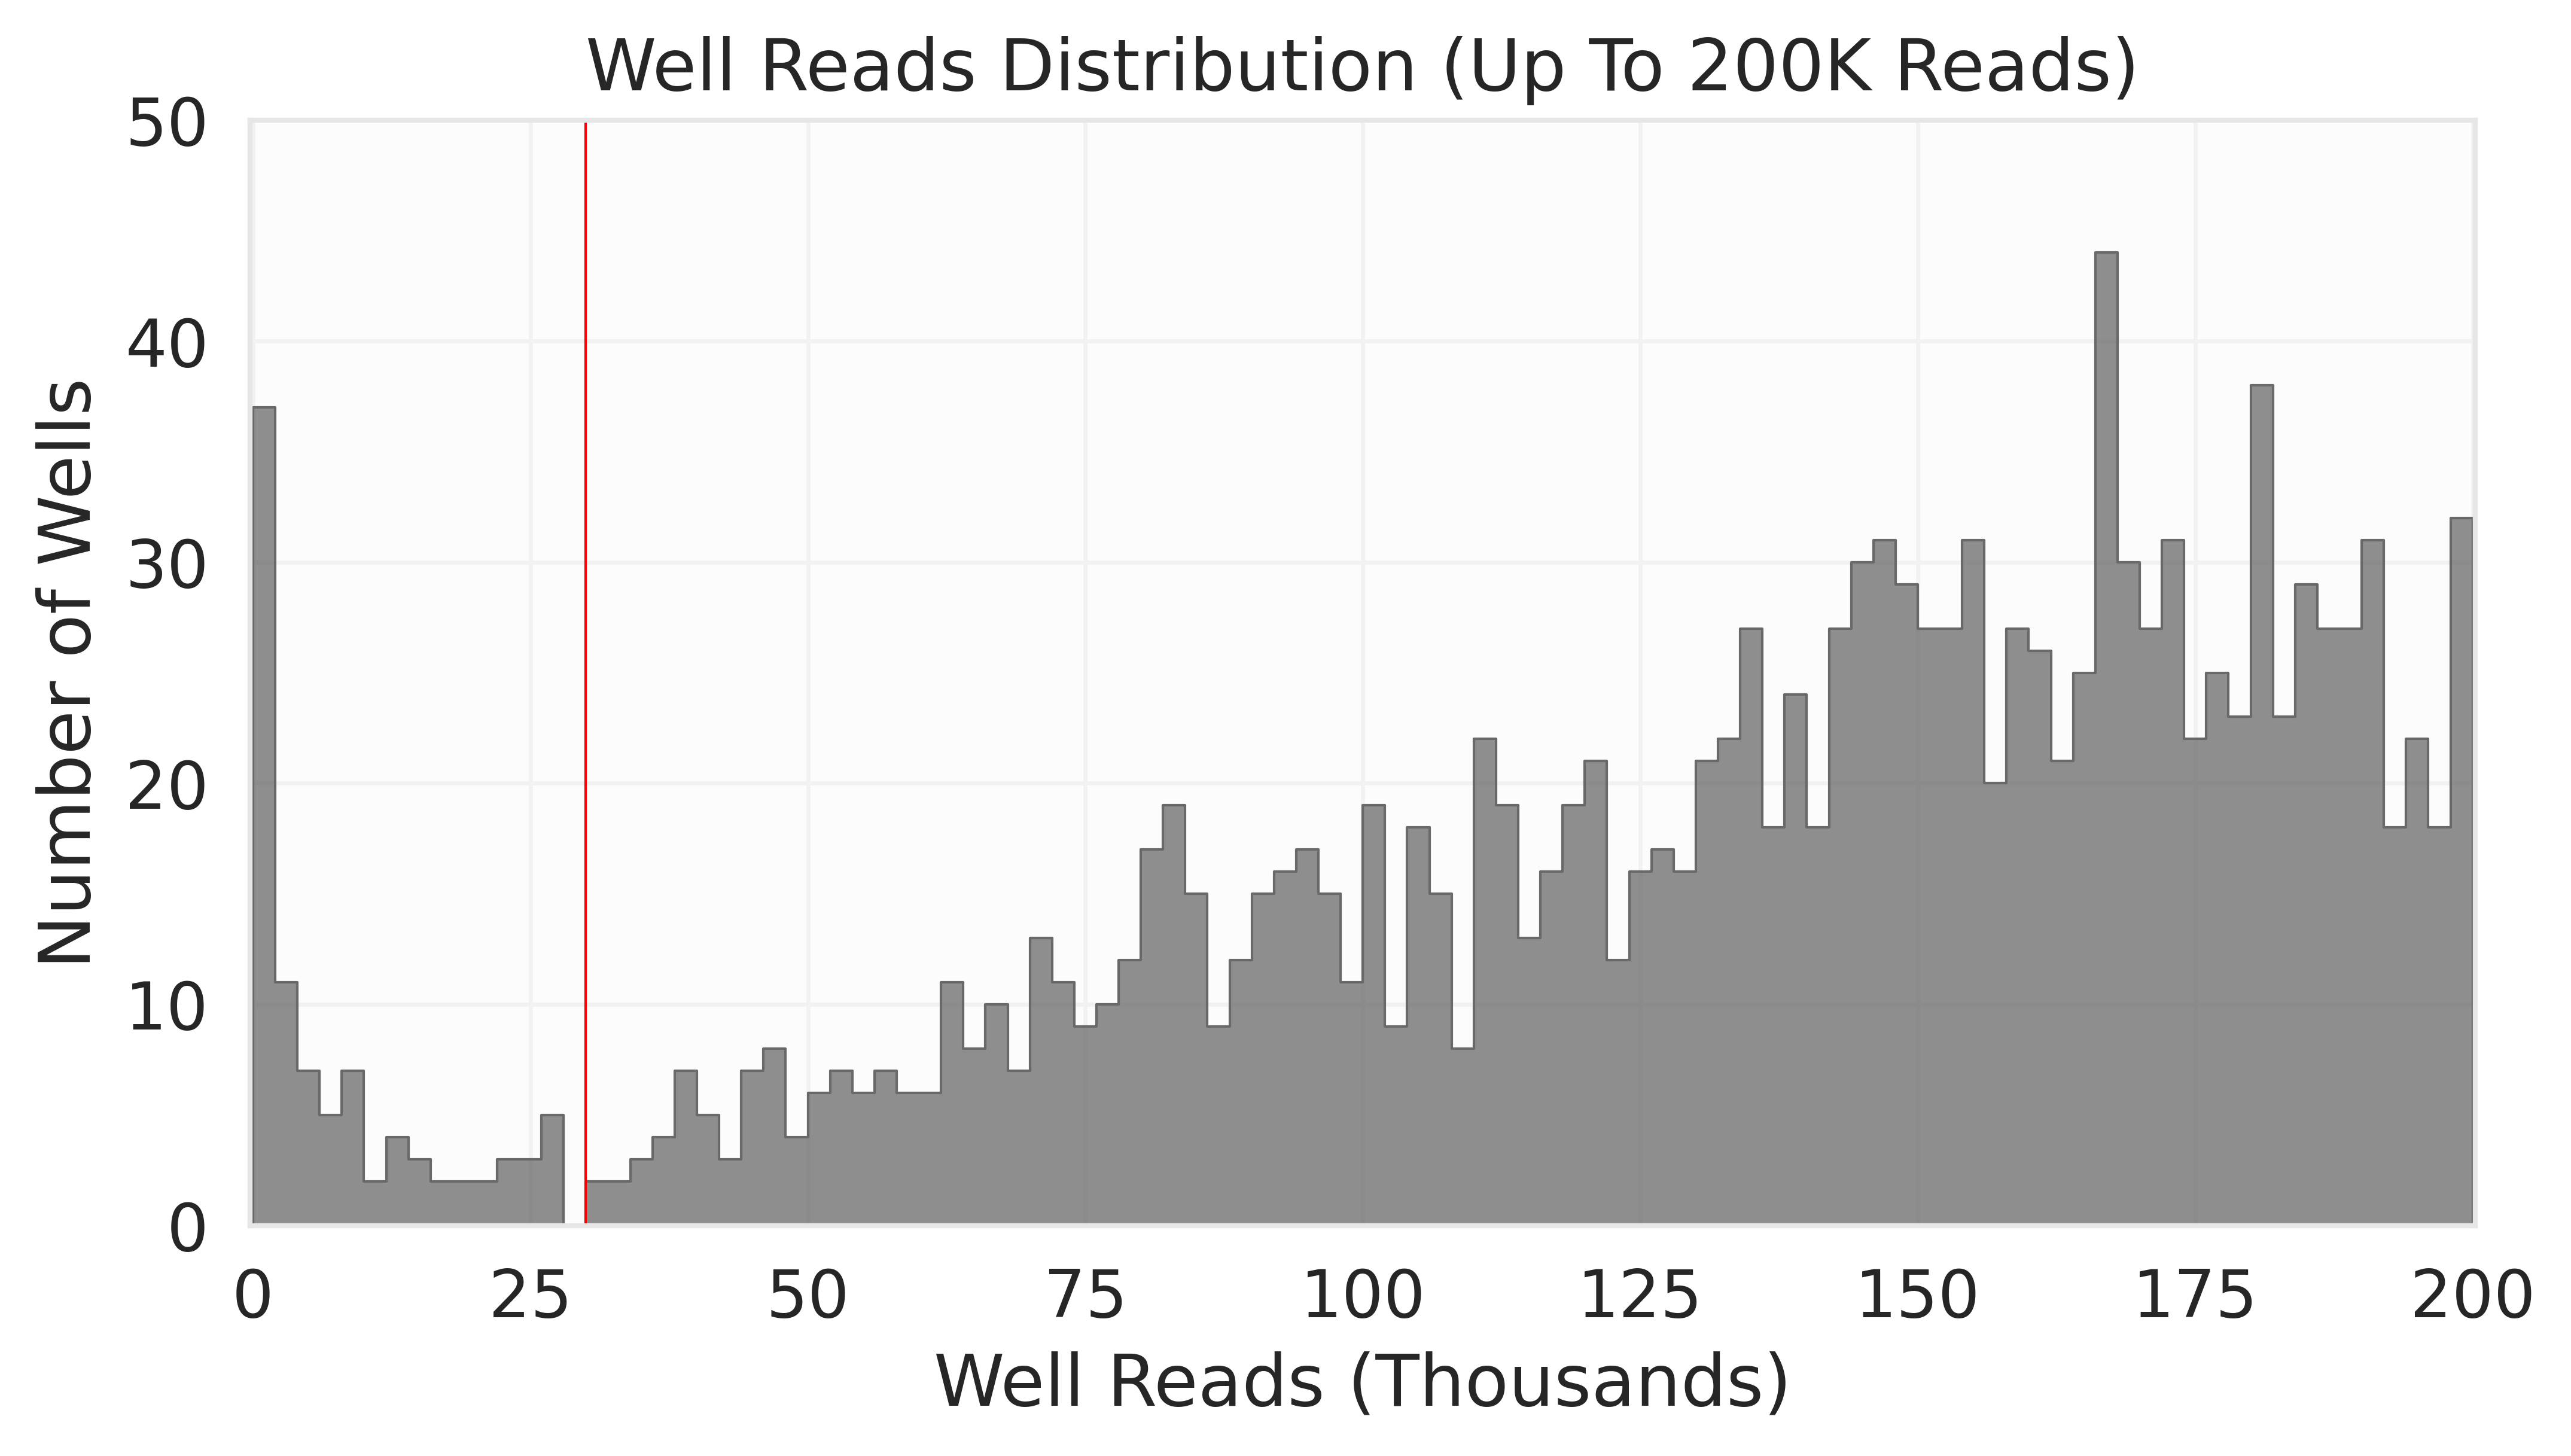

In [4]:
def makeWellCountHist():
    
    plates = readPlates()
    
    wellCounts = list()
    for rundate,rundf in plates.groupby("run"):
        rundir = os.path.join(countsdir, rundate)
        for countsfile in os.listdir(rundir):
            plate = countsfile[:countsfile.rfind('_')]
            if plate in rundf.plate.tolist():
                df = pd.read_csv(os.path.join(rundir, countsfile))
                for _,welldf in df.groupby("well"):
                    wellCounts.append(welldf.counts.sum())
        
    def _makeHist(title, ymax, bins, binrange=None):
        
        with sns.axes_style(style=style, rc=rc):
            
            fig = plt.figure(figsize=(8,4), dpi=600)
            ax = sns.histplot(
                x=[x/1000 for x in wellCounts],
                bins=bins,
                binrange=binrange,
                color="dimgray",
                element="step",
                linewidth=0.5)
            
            plt.vlines(
                x=30,
                ymin=0,
                ymax=ymax,
                color="red",
                linewidth=0.5)
            
            plt.xlim([-0.25,max(binrange)+0.25] if binrange else [-2,ax.get_xlim()[1]])
            plt.ylim([0,ymax])
            plt.ylabel
            plt.xlabel("Well Reads (Thousands)")
            plt.ylabel("Number of Wells")
            plt.title(title)

            return fig

    rundates = ', '.join(sorted(plates.run.unique()))
    fig = _makeHist(
        title="Well Reads Distribution".format(),
        bins=150,
        ymax=100)
    fig.savefig(os.path.join(figsdir,"fig_s5b.svg"), format="svg", bbox_inches="tight")

    maxCounts = 200
    fig = _makeHist(
        "Well Reads Distribution (Up To {}K Reads)".format(maxCounts),
        ymax=50,
        bins=100,
        binrange=[0,maxCounts])
    fig.savefig(os.path.join(figsdir,"fig_s5c.svg"), format="svg", bbox_inches="tight")
        

makeWellCountHist()

In [5]:
def getHits(scores, magratiothresh):
    hits = scores[scores.apply(
        lambda row:
            (row.pvalpos  <  pvalposthresh) &
            (row.magratio > magratiothresh) &
            (row.well not in PlateLayout(row.plate).getPosCtrl()),
        axis=1)].copy()
    return hits.sort_values(by="magratio", ascending=False)


print("getting hits...", end='')
hits = getHits(scores, magratiothresh=magratiothresh)
print("done")

getting hits...done


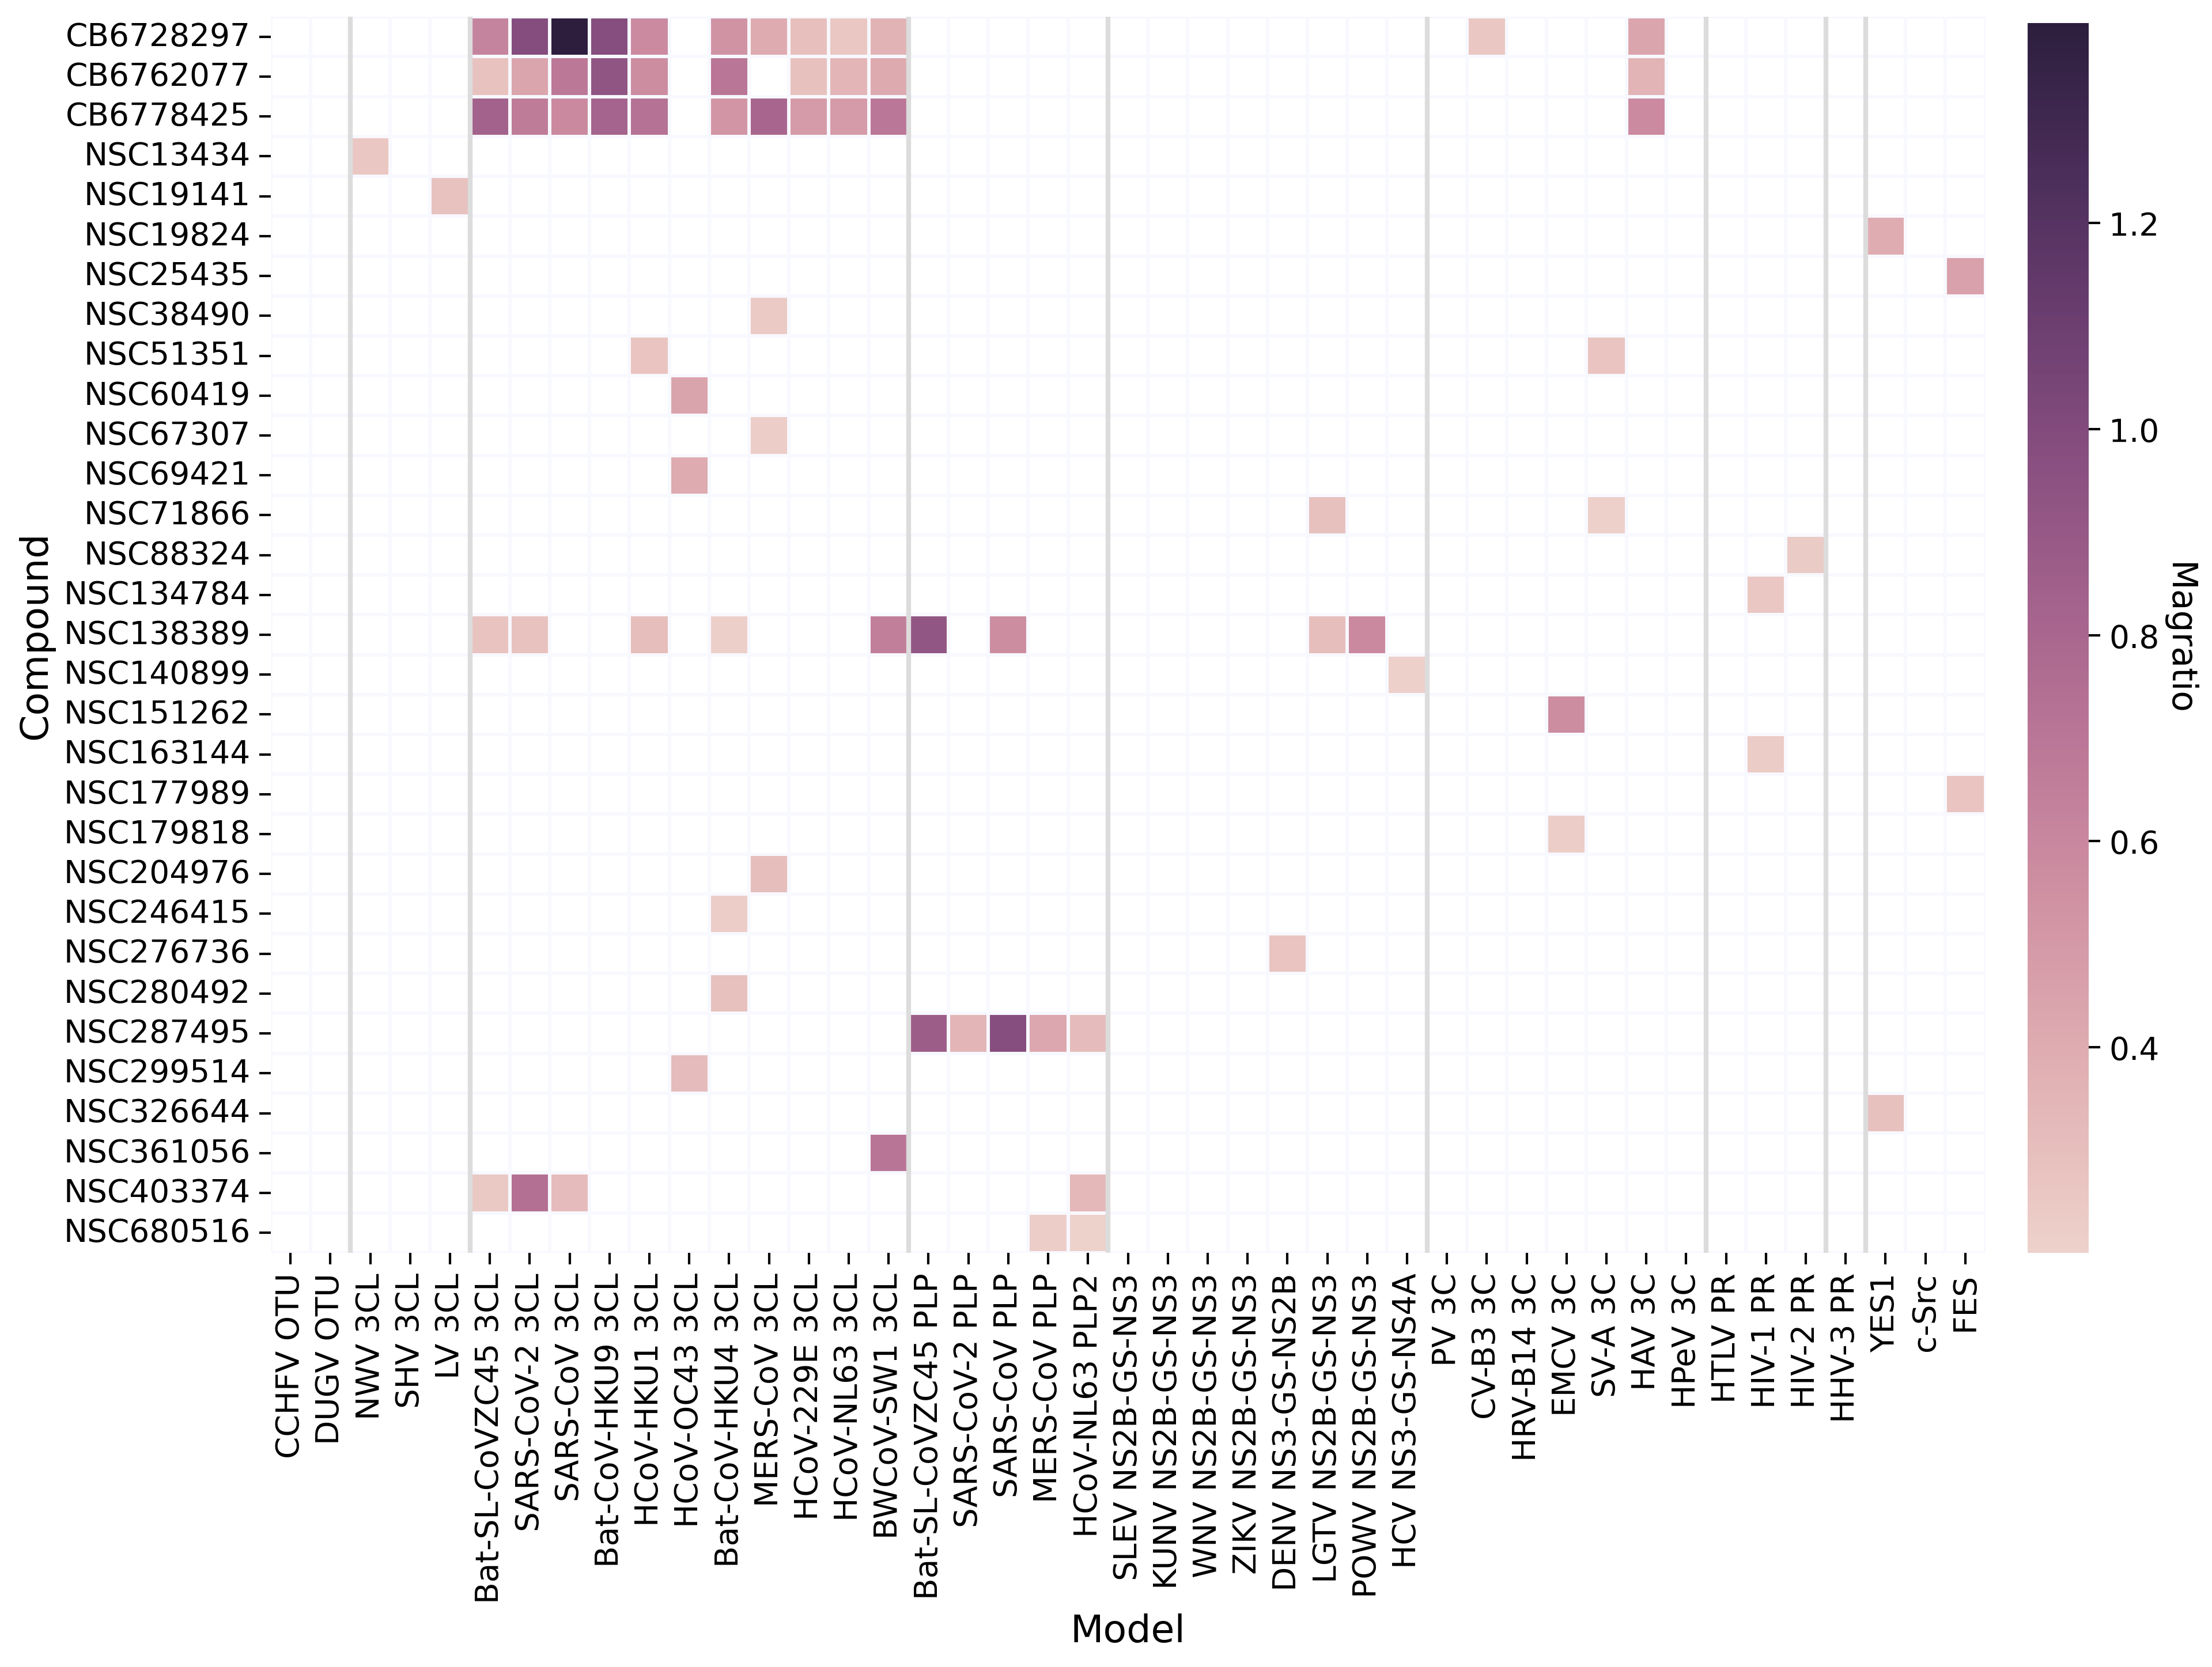

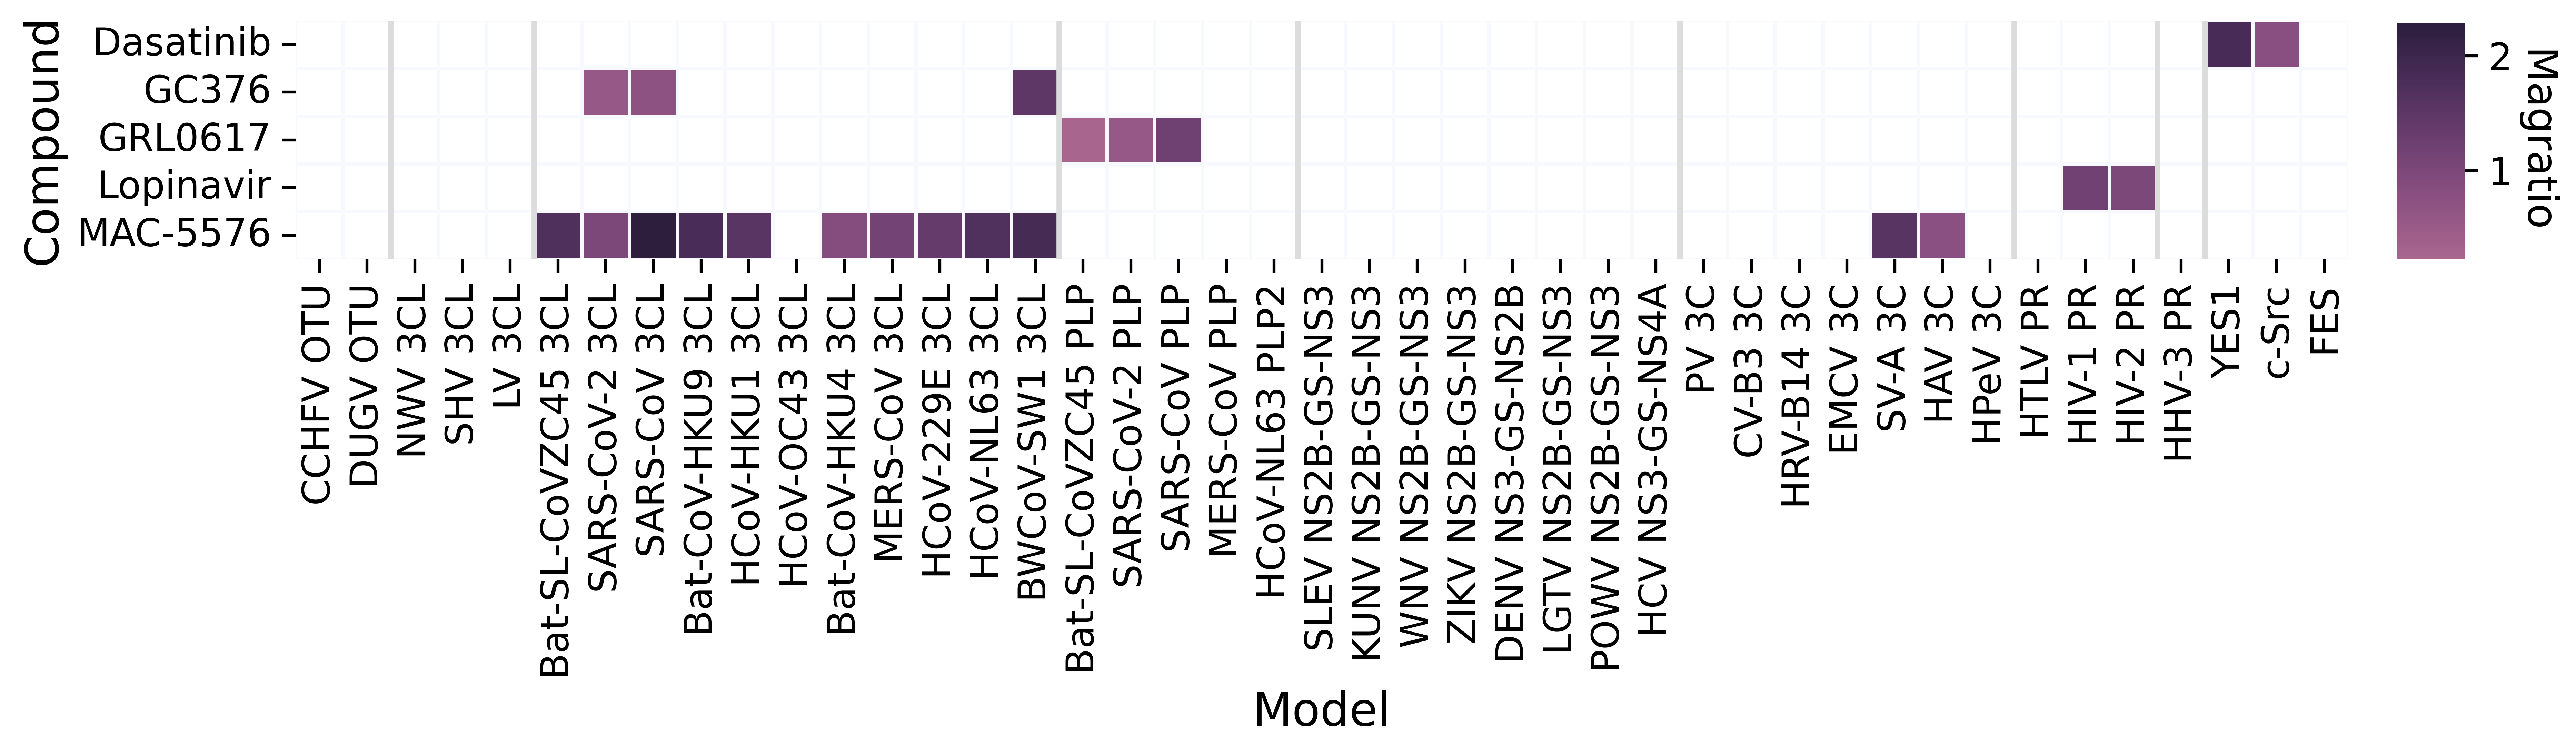

In [6]:
modelmap = getModelDisplayNames()


def plotTargetFamilyLines():
    plt.vlines(
        [2, 5, 16, 21, 29, 36, 39, 40],
        0,
        len(hits),
        color="gainsboro",
        linewidth=2)


def makeHitsHeatmap(hits):
    hits["gene"] = hits.gene.apply(lambda x: modelmap.get(x,x))
    hits["compound"] = hits.compoundsrc + hits.compoundid
    
    hits = hits.pivot(
        index   = "compound",
        columns = "gene",
        values  = "magratio")
    for model in modelmap.values():
        if model not in hits.columns:
            hits[model] = np.nan
    hits = hits[modelmap.values()]
    compounds = [("CB",int(x[2:])) if x.startswith("CB") else ("NSC",int(x[3:]))
        for x in hits.index.tolist()]
    compounds = ["{}{}".format(*x) for x in sorted(compounds)]
    hits = hits.loc[compounds]
    fig, ax = plt.subplots(figsize=(16,12), dpi=300)
    sns.heatmap(
        ax=ax,
        data=hits,
        cmap=sns.cubehelix_palette(as_cmap=True),
        square=True,
        linewidth=1,
        linecolor="ghostwhite",
        xticklabels=True,
        yticklabels=True,
        cbar_kws={
            "aspect":20,
            "panchor":(0,0),
            "anchor":(-0.25,0),
            "shrink":0.77})
    plt.xlabel("Model",    fontsize=16)
    plt.ylabel("Compound", fontsize=16)
    cbar = fig.axes[-1]
    cbar.get_yaxis().labelpad = 15
    cbar.set_ylabel("Magratio", rotation=270)
    plotTargetFamilyLines()

    fig.savefig(os.path.join(figsdir,"fig_3a.svg"), format="svg", bbox_inches="tight")


def makeDenseHeatmap(hits, genenorm, cbaspect, cbshrink):
    hits = hits[hits.gene.apply(lambda x: x in modelmap)].copy()
    hits["gene"] = hits.gene.apply(lambda x: modelmap[x])
    hits["compound"] = hits.well
    
    if not genenorm: 
        hits.magratio = np.log(hits.p / hits.kinasenorm) / np.log(hits.pvalpos)
    
    hits.magratio = hits.magratio.apply(lambda x: None if x < magratiothresh else x)
    
    comporder = list(hits.compound.unique())
    hits = hits.pivot(
        index="compound",
        columns="gene",
        values="magratio")
    hits = hits.sort_index(key = lambda idx: idx.map(lambda x: comporder.index(x)))
    hits = hits[[v for v in modelmap.values() if v in hits.columns]]
    fig, ax = plt.subplots(figsize=(16,4), dpi=600)
    sns.heatmap(
        ax=ax,
        data=hits,
        cmap=sns.cubehelix_palette(as_cmap=True),
        center=magratiothresh,
        square=True,
        linewidth=1,
        linecolor="ghostwhite",
        xticklabels=True,
        yticklabels=True,
        cbar_kws={
            "aspect":cbaspect,
            "panchor":(0,0),
            "anchor":(-0.25,0),
            "shrink":cbshrink})
    plt.xlabel("Model",    fontsize=16)
    plt.ylabel("Compound", fontsize=16)
    cbar = fig.axes[-1]
    cbar.get_yaxis().labelpad = 15
    cbar.set_ylabel("Magratio", rotation=270)
    plotTargetFamilyLines()
    
    fig.savefig(os.path.join(figsdir,"fig_2f.svg"), format="svg", bbox_inches="tight")


def readPosCtrlPlate():
    df = pd.read_csv(os.path.join(hitsdir, "221126.csv"))
    df.well = df.well.apply(
        lambda x: x[x.index('_')+1:x.index('.')])
    df.well = df.well.apply(lambda x: x.replace("MAC5576","MAC-5576"))
    return df


makeHitsHeatmap(hits.copy())
makeDenseHeatmap(readPosCtrlPlate(), genenorm=False, cbaspect=3.5, cbshrink=0.37)